# DGCNN

In [1]:
# Always reload in jupyter notebook
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from dgcnn.data import load_data_cls, load_data_partseg, load_data_semseg
from dgcnn.data import ModelNet40
from dgcnn.model import PointNet, DGCNN, DGCNN_partseg, DGCNN_semseg_s3dis
from torch.utils.data import DataLoader
from dgcnn.util import cal_loss, IOStream
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

## Classification

In [25]:
X_train, y_train = load_data_cls('train')
X_test, y_test = load_data_cls('test')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9840, 2048, 3) (9840, 1)
(2468, 2048, 3) (2468, 1)


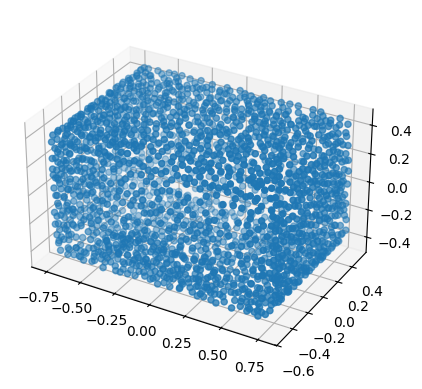

In [26]:
def plot_3d_shapes(X, y, ind):
    # Plot with the same scale for the axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[ind][:, 0], X[ind][:, 2], X[ind][:, 1])
    ax.set_aspect('equal', adjustable='box')
    plt.show()

plot_3d_shapes(X_train, y_train, 3)

## Training

Defining training functions

In [4]:
def init_experiment(exp_name):
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    if not os.path.exists('checkpoints/'+exp_name):
        os.makedirs('checkpoints/'+exp_name)
    if not os.path.exists('checkpoints/'+exp_name+'/'+'models'):
        os.makedirs('checkpoints/'+exp_name+'/'+'models')
    return IOStream('checkpoints/'+exp_name+'/run.log')

def train(exp_name, model, epochs, batch_size, test_batch_size, num_points, io, lr=0.001):
    train_loader = DataLoader(ModelNet40(partition='train', num_points=num_points), num_workers=8,
                              batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(ModelNet40(partition='test', num_points=num_points), num_workers=8,
                             batch_size=test_batch_size, shuffle=True, drop_last=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
        model = nn.DataParallel(model)
        io.cprint("Let's use " + str(torch.cuda.device_count()) + " GPUs.")
    else:
        io.cprint("Using CPU.")
    model.to(device)

    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(opt, epochs, eta_min=lr) 
    criterion = cal_loss

    best_test_acc = 0
    for epoch in range(epochs):
        ####################
        # Train
        ####################
        train_loss = 0.0
        count = 0.0
        model.train()
        train_pred = []
        train_true = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            opt.zero_grad()
            logits = model(data)
            loss = criterion(logits, label)
            loss.backward()
            opt.step()
            preds = logits.max(dim=1)[1]
            count += batch_size
            train_loss += loss.item() * batch_size
            train_true.append(label.cpu().numpy())
            train_pred.append(preds.detach().cpu().numpy())
        del data, label, logits, loss, preds
        torch.cuda.empty_cache()
        scheduler.step()
        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f' % (epoch,
                                                                                 train_loss*1.0/count,
                                                                                 metrics.accuracy_score(
                                                                                     train_true, train_pred),
                                                                                 metrics.balanced_accuracy_score(
                                                                                     train_true, train_pred))
        io.cprint(outstr)

        ####################
        # Test
        ####################
        test_loss = 0.0
        count = 0.0
        model.eval()
        test_pred = []
        test_true = []
        for data, label in test_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            logits = model(data)
            loss = criterion(logits, label)
            preds = logits.max(dim=1)[1]
            count += batch_size
            test_loss += loss.item() * batch_size
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
        del data, label, logits, loss, preds
        torch.cuda.empty_cache()
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        test_acc = metrics.accuracy_score(test_true, test_pred)
        avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
        outstr = 'Test %d, loss: %.6f, test acc: %.6f, test avg acc: %.6f' % (epoch,
                                                                              test_loss*1.0/count,
                                                                              test_acc,
                                                                              avg_per_class_acc)
        io.cprint(outstr)
        if test_acc >= best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'checkpoints/%s/models/model.t7' % exp_name)


def test(model, test_batch_size, num_points, io):
    test_loader = DataLoader(ModelNet40(partition='test', num_points=num_points),
                             batch_size=test_batch_size, shuffle=True, drop_last=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
        model = nn.DataParallel(model)
        io.cprint("Let's use " + str(torch.cuda.device_count()) + " GPUs.")
    else:
        io.cprint("Using CPU.")
    model.to(device)

    model = model.eval()
    test_acc = 0.0
    test_true = []
    test_pred = []
    for data, label in test_loader:
        data, label = data.to(device), label.to(device).squeeze()
        data = data.permute(0, 2, 1)
        logits = model(data)
        preds = logits.max(dim=1)[1]
        test_true.append(label.cpu().numpy())
        test_pred.append(preds.detach().cpu().numpy())
    del data, label, logits, preds
    torch.cuda.empty_cache()
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    test_acc = metrics.accuracy_score(test_true, test_pred)
    avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
    outstr = 'Test :: test acc: %.6f, test avg acc: %.6f'%(test_acc, avg_per_class_acc)
    io.cprint(outstr)

In [ ]:
exp_name = 'dgcnn_1'
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
epochs = 2
batch_size = 8
test_batch_size = 8
num_points = 1024

io = init_experiment(exp_name)
train(exp_name, model, epochs, batch_size, test_batch_size, num_points, io)

Let's use 1 GPUs.
Train 0, loss: 2.554852, train acc: 0.500610, train avg acc: 0.318444
Test 0, loss: 2.083805, test acc: 0.675041, test avg acc: 0.560331
Train 1, loss: 2.108054, train acc: 0.683841, train avg acc: 0.526940
Test 1, loss: 1.794963, test acc: 0.815640, test avg acc: 0.683779


## Using pretrained model

In [29]:
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
pointnet = PointNet(emb_dims=1024)
num=0
for param in model.parameters():
    if param.requires_grad:
        num += param.numel()
print("Number of parameters in DGCNN: ", num)
num=0
for param in pointnet.parameters():
    if param.requires_grad:
        num += param.numel()
print("Number of parameters in PointNet: ", num)

Number of parameters in DGCNN:  1809576
Number of parameters in PointNet:  696168


In [30]:
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

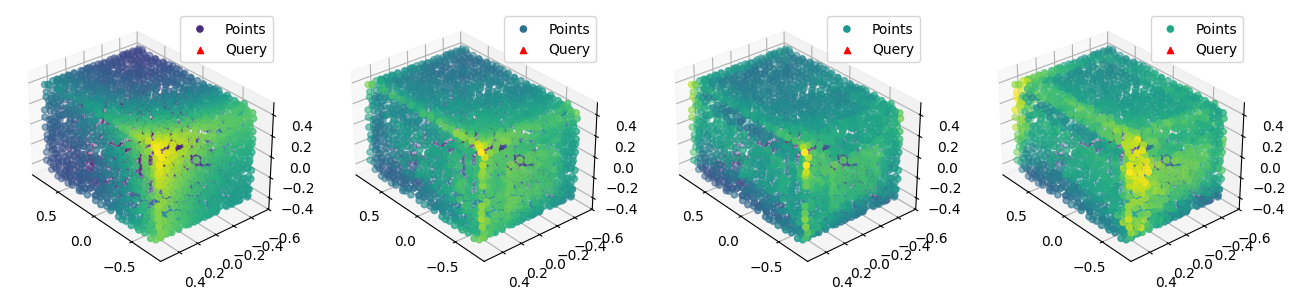

In [31]:
def plot_knn(model, points, idx, device):
    X_points = torch.Tensor(points).squeeze().unsqueeze(0).to(device)
    _, knn_idx = model(X_points.permute(0, 2, 1), return_idx=True)

    X_points = X_points.squeeze().detach().cpu().numpy()
    nb_step = len(knn_idx)

    fig, ax = plt.subplots(ncols=nb_step, nrows=1, figsize=(4*nb_step, 4), subplot_kw=dict(projection='3d'))

    for step, step_knn_idx in enumerate(knn_idx):
        step_knn_idx = step_knn_idx.squeeze().detach().cpu().numpy()
        ax[step].scatter(X_points[:, 0], X_points[:, 2], X_points[:, 1], c=step_knn_idx[idx], marker='o', label='Points')
        ax[step].scatter(X_points[idx, 0], X_points[idx, 2], X_points[idx, 1], c='r', marker='^', label='Query')
        ax[step].set_aspect('equal', adjustable='box')
        ax[step].legend()
        ax[step].view_init(azim=140, elev=30)
    plt.legend()
    plt.show()

#%matplotlib inline
dataset_idx = 3
point_idx = 1600
X_test_ind = X_train[dataset_idx]
plot_knn(model, X_test_ind, point_idx, device)


# Object segmentation

In [6]:
X, label, y = load_data_partseg()
print(X.shape, label.shape, y.shape)

(2874, 2048, 3) (2874, 1) (2874, 2048)


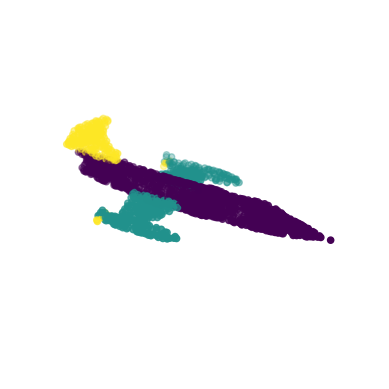

In [7]:
ind = 4
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[ind,:,0], X[ind,:,2], X[ind,:,1], c=y[ind])
ax.set_aspect('equal', adjustable='box')
ax.axis('off')
plt.show()

In [ ]:
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Scene segmentation

In [8]:
X, color, y = load_data_semseg()
print(X.shape, color.shape, y.shape)

(68, 289724, 3) (68, 289724, 3) (68, 289724)


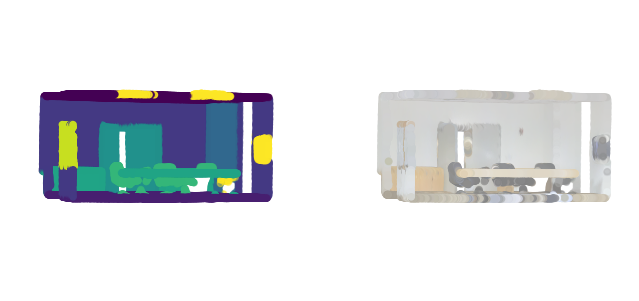

In [ ]:
ind = 4
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(4*2, 4), subplot_kw=dict(projection='3d'))
ax[0].scatter(X[ind,:40000, 0], X[ind,:40000, 1], X[ind,:40000, 2], c=y[ind,:40000])
ax[0].set_aspect('equal', adjustable='box')
ax[0].view_init(azim=160, elev=0)
ax[0].axis('off')
ax[1].scatter(X[ind,:40000, 0], X[ind,:40000, 1], X[ind,:40000, 2], c=(color[ind,:40000,:]/255.0 + 1)/2)
ax[1].set_aspect('equal', adjustable='box')
ax[1].view_init(azim=160, elev=0)
ax[1].axis('off')
plt.show()